In [73]:
import os
import re
import time
import torch
import random
import transformers
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch import nn,optim
import nltk
# Uncomment to download "stopwords"
from nltk.corpus import stopwords

from sklearn.utils import shuffle
from json_tools import load_json, dump_json
from transformers import BertTokenizer

from torch.utils.tensorboard import SummaryWriter  
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset,Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, precision_score,recall_score

# load data

In [74]:

datas = load_json("ps_sents_pair_with_label_origin.json")

In [75]:
#shuffle datas
datas = shuffle(shuffle(datas,random_state=22),random_state=22)

In [76]:
train,test = train_test_split(datas,test_size=0.2, random_state=2022)
test,val = train_test_split(test,test_size=0.5, random_state=2022)
len(train),len(test),len(val)

(21510, 2689, 2689)

##### complaint dataset

In [77]:
 # Load data and set labels
data_complaint = pd.read_csv('data/complaint1700.csv').tweet.values

data_non_complaint = pd.read_csv('data/noncomplaint1700.csv').tweet.values
sent_pairs = []
for i,j in zip(shuffle(data_complaint, random_state=2022), shuffle(data_non_complaint, random_state=2022)):
    dic01 ={"sent1": i,"sent2":j,'label':0}
    sent_pairs.append(dic01)
for i,j in zip(shuffle(data_complaint, random_state=2022), shuffle(data_complaint, random_state=2022)):
    dic00 ={"sent1": i,"sent2":j,'label':1}
    sent_pairs.append(dic00)
sent_pairs = [sents for sents in sent_pairs if len(sents["sent1"])>30 and len(sents["sent2"])> 30]
dump_json(sent_pairs,"ps_sents_pair_with_label_data_complaint.json")
len(sent_pairs)

3349

In [78]:
train,test = train_test_split(sent_pairs,test_size=0.1, random_state=2022)
test,val = train_test_split(test,test_size=0.5, random_state=2022)
len(train),len(test),len(val)

(3014, 167, 168)

# Load the BERT tokenizer

In [79]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True,cache_dir=os.path.join(os.getcwd(),"bert-base-uncased_cache"))


# find the maximum length

In [80]:

sents1 = [d["sent1"].lower() for d in datas]
sents2 = [d["sent2"].lower() for d in datas]
sents = list(set(sents1+sents2))
# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in sents]
# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  113


In [81]:
# specify a MAX_LEN you like
MAX_LEN=128

In [82]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


def text_preprocessing_data2(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

# set device

In [83]:
def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        print('Device name:', torch.cuda.get_device_name(0))

    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    return device
device = get_device()

No GPU available, using the CPU instead.


# Create a function to tokenize a set of texts

In [123]:

def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    token_type_ids= []
    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing_data2(sent['sent1'].lower()),#The first sequence to be encoded
            text_pair=text_preprocessing_data2(sent["sent2"].lower()),# second sequence to be encoded
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            truncation=True,
            pad_to_max_length=True,         # Pad sentence to max length
            return_token_type_ids=True,
#             return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
        token_type_ids.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    token_type_ids =  torch.tensor(token_type_ids)
    return input_ids, attention_masks, token_type_ids

In [122]:
def preprocessing_for_bert_two_sent(data):
    input_ids = []
    attention_masks = []
    token_type_ids= []
    for sent in data:
        A = tokenizer.encode(sent['sent1'])
        B = tokenizer.encode(sent['sent1'])[1:]
        input_id= A + B
        if len(input_id) > MAX_LEN:
            input_id = input_id[:MAX_LEN]
            train_mask = len(input_id)*[1]
            token_type_id = train_mask
        else: 
            train_mask = len(input_id)*[1] + (MAX_LEN - len(input_id))*[0]
            token_type_id = train_mask
            input_id += (MAX_LEN - len(input_id))*[0]
        # Add the outputs to the lists
        input_ids.append(input_id)
        attention_masks.append(train_mask)
        token_type_ids.append(token_type_id)
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    token_type_ids =  torch.tensor(token_type_ids)
    return input_ids, attention_masks, token_type_ids

In [124]:
#Convert  labels to torch.Tensor
train_labels = torch.tensor([t["label"] for t in train])
test_labels = torch.tensor([t["label"] for t in test])
val_labels = torch.tensor([t["label"] for t in val])
train_labels,test_labels,val_labels

(tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
         0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
         1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
         0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
         1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
         0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
         0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]),
 tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
         1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
         1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
         0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 

In [125]:
train_labels[0]

tensor(0)

In [126]:
torch.count_nonzero(train_labels).item(),len(train_labels)-torch.count_nonzero(train_labels).item()

(1507, 1507)

In [127]:
torch.count_nonzero(test_labels).item(),len(test_labels)-torch.count_nonzero(test_labels).item()

(88, 79)

In [128]:
torch.count_nonzero(val_labels).item(),len(val_labels)-torch.count_nonzero(val_labels).item()

(86, 82)

In [129]:
# 
train_inputs, train_masks , train_token_type_ids = preprocessing_for_bert(train)
test_inputs, test_masks, test_token_type_ids= preprocessing_for_bert(test)
val_inputs, val_masks ,val_token_type_ids= preprocessing_for_bert(val)

In [130]:
train_masks[123]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [131]:
train_inputs[123]

tensor([  101,  5139, 22610, 16764,  6032,  3291,  1029, 14145,  2080, 12954,
         2773, 13828,  2064, 10651,  2149,  5064,  1029,  8299,  2522,  1038,
        16409,  2290,  2480,  2546, 24703,  2575,  2595,   102,  5139, 22610,
        16764,  6032,  3291,  1029, 14145,  2080, 12954,  2773, 13828,  2064,
        10651,  2149,  5064,  1029,  8299,  2522,  1038, 16409,  2290,  2480,
         2546, 24703,  2575,  2595,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [132]:
train_token_type_ids[123]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

# Create PyTorch DataLoader

In [136]:
#Create PyTorch DataLoader

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks,train_token_type_ids, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
test_data = TensorDataset(test_inputs, test_masks,test_token_type_ids, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_token_type_ids,val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create BertClassifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.

The transformers library has the BertForSequenceClassification class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward neural network as our classifier.

In [151]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        # bert base 768 hidden dimension
        # bert large 1024 hidden dimension
        D_in, H, D_out = 768, 50, 2
        unfreeze_layers = ['layer.10','layer.11','bert.pooler','out.']
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased',cache_dir=os.path.join(os.getcwd(),"bert-base-uncased_cache"))

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
#             for name, param in self.bert.named_parameters():
#                 print(name,param.size())
 
#             print("*"*30)
#             print('\n')
 
            for name ,param in self.bert.named_parameters():
                param.requires_grad = False
                for ele in unfreeze_layers:
                    if ele in name:
                        param.requires_grad = True
                        break
#             #验证一下
#             for name, param in self.bert.named_parameters():
#                 if param.requires_grad:
#                     print(name,param.size())

        
    def forward(self, input_ids, attention_mask, token_type_ids):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            token_type_ids=token_type_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

# Optimizer & Learning Rate Scheduler

recommend following hyper-parameters
   - Batch size: 16 or 32       
   - Learning rate (Adam): 5e-5, 3e-5 or 2e-5  
   - Number of epochs: 2, 3, 4  

In [152]:
def get_scheduler(optimizer, scheduler: str, warmup_steps: int, t_total: int):
        """
        Returns the correct learning rate scheduler
        """
        scheduler = scheduler.lower()
        if scheduler == 'constantlr':
            return transformers.get_constant_schedule(optimizer)
        elif scheduler == 'warmupconstant':
            return transformers.get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)
        elif scheduler == 'warmuplinear':
            return transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)
        elif scheduler == 'warmupcosine':
            return transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)
        elif scheduler == 'warmupcosinewithhardrestarts':
            return transformers.get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)
        else:
            raise ValueError("Unknown scheduler {}".format(scheduler))


In [154]:
len_train_step = len(train_dataloader)
print('len_train_step: ',len_train_step)

def initialize_model(epochs=4,fp16=False,n_gpu=0,local_rank=-1):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    # bert_layers越小，学习率应该要越大
    #optimizer = AdamW(bert_classifier.parameters(),
    #                  lr=5e-5,    # Default learning rate
    #                 eps=1e-8    # Default epsilon value
    #                  )
    # 定义优化器
    optimizer = optim.Adam(
                            bert_classifier.parameters(),
                            lr=5e-5,
                            betas=(0.9, 0.999),
                            eps=1e-08,
                            weight_decay=0,
                            amsgrad=False)# Adam梯度下降
    # Total number of training steps
    total_steps = len_train_step * epochs
    warm_up_ratio = 0.0 # 定义要预热的step
    # Set up the learning rate scheduler
    # https://blog.csdn.net/orangerfun/article/details/120400247
    #scheduler = get_linear_schedule_with_warmup(optimizer,
    #                                           num_warmup_steps=warm_up_ratio*total_steps, # Default value
    #                                            num_training_steps=total_steps)
    scheduler = get_scheduler(optimizer, 'warmuplinear', warm_up_ratio*total_steps, total_steps)
    #### Optional configuration
#     if fp16:"Whether to use 16-bit (mixed) precision (through NVIDIA apex) instead of 32-bit"
#         try:
#             from apex import amp
#             fp16_opt_level = '01'
#         except ImportError:
#             raise ImportError("Please install apex from "
#             "https://www.github.com/nvidia/apex to use fp16 training.")
#         bert_classifier, optimizer = amp.initialize(
#             bert_classifier, optimizer, opt_level=fp16_opt_level)
#         "For fp16: Apex AMP optimization level "
#         "selected in ['O0', 'O1', 'O2', and 'O3']."
#         "See details at https://nvidia.github.io/apex/amp.html"
#     # multi-gpu training (should be after apex fp16 initialization)
#     if n_gpu > 1:
#         bert_classifier = torch.nn.DataParallel(bert_classifier)
        
#      # Distributed training (should be after apex fp16 initialization)
#     if local_rank != -1:
#         bert_classifier = torch.nn.parallel.DistributedDataParallel(
#             bert_classifier, 
#             device_ids=[local_rank],
#             output_device=local_rank,
#             find_unused_parameters=True
#             )
        
    return bert_classifier, optimizer, scheduler


len_train_step:  189


# Training Loop

Training:

- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (loss.backward())
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (optimizer.step())
- Update the learning rate (scheduler.step())

Evaluation:

- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

In [141]:
writer = SummaryWriter('./log/adam_base_large_lr=5e-5droupout=0.0warmup=0.0batchsize=16unfreeze_bert_10_Dec_complaint')

In [142]:
# Specify loss function
# loss_fn = nn.CrossEntropyLoss(reduction='mean',label_smoothing=0.05)
loss_fn = nn.CrossEntropyLoss(reduction='mean')#https://blog.csdn.net/zyoung17/article/details/108430465
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    one_cricle_length = len(train_dataloader)
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val F1':^9} | {'Elapsed/lr':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask,b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids,b_token_type_ids, b_attn_mask)
#             print('logits,b_labels')
#             print(logits)
#             print(b_labels)
            '''tensor([[-0.0491,  0.1918],
                       [-0.0062,  0.1743],
                       [-0.0856,  0.2257],
                       [-0.0044,  0.1629]], grad_fn=<AddmmBackward>)
                tensor([0, 1, 0, 0])
            '''
            #print(logits.shape)  #torch.Size([4, 2]), 4是batch_size, 2是类别
            #print(b_labels.shape) #torch.Size([4])
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            #print(loss)
            #print(logits.shape,b_labels.shape,loss.shape)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()
#             b = 0.64
#             flood = (loss-b).abs()+b
#             flood.backward()
            
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients",L2 norm fuc
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0, norm_type=2)

            # Update parameters and the learning rate
            op_params =optimizer.state_dict()['param_groups'][0]
            lr = op_params.get('lr')
            
            ########################################################################
            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                writer.add_scalar('step/train_loss_step', batch_loss / batch_counts, step + epoch_i*one_cricle_length)
                writer.add_scalar('step/train_lr_step', lr, step + epoch_i*one_cricle_length)

                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
#                 writer.add_scalar('steploss/train_loss_step', batch_loss / batch_counts, step)
                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {lr}")
                
                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
            ###############################################################
            optimizer.step()
            scheduler.step()
        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_f1, val_accuracy, val_p1, val_r1 = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            writer.add_scalar('loss/train_loss', avg_train_loss, epoch_i)
            writer.add_scalar('loss/val_loss', val_loss, epoch_i)
            writer.add_scalar('matrix/val_f1', val_f1, epoch_i)
            writer.add_scalar('matrix/val_p1', val_p1, epoch_i)
            writer.add_scalar('matrix/val_r1', val_r1, epoch_i)
            writer.add_scalar('matrix/val_accuracy', val_accuracy, epoch_i)
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_f1:^9.2f} | {time_elapsed:^15.6f}")
            print("-"*70)
        print("\n")
    writer.close()
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    val_f1 = []
    val_p0,val_p1,val_r0,val_r1 = [],[],[],[]

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids,b_token_type_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        #print(preds)
        #print(b_labels)
        # Calculate the accuracy rate
        # accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        #accuracy = (preds == b_labels).cpu().numpy().mean()
        accuracy = accuracy_score(b_labels, preds,  normalize=True)
        f1 = f1_score(b_labels, preds, average='weighted')
        precision = precision_score(b_labels, preds, average='weighted')
        recall = recall_score(b_labels, preds, average='weighted')
        val_f1.append(f1)
        val_accuracy.append(accuracy)
        val_p1.append(precision)
        val_r1.append(recall)
    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_f1 = np.mean(val_f1)
    val_accuracy = np.mean(val_accuracy)
    val_p0 = np.mean(val_p0)
    val_p1 = np.mean(val_p1)
    val_r0 = np.mean(val_r0)
    val_r1 = np.mean(val_r1)

    return val_loss, val_f1, val_accuracy,val_p1,val_r1

# running

In [144]:
epochs=3
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=epochs)
train(bert_classifier, train_dataloader, val_dataloader, epochs=epochs, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val F1   | Elapsed/lr
----------------------------------------------------------------------
   1    |   20    |   0.236495   |     -      |     -     | 4.82363315696649e-05
   1    |   40    |   0.007860   |     -      |     -     | 4.647266313932981e-05
   1    |   60    |   0.003752   |     -      |     -     | 4.470899470899471e-05
   1    |   80    |   0.002663   |     -      |     -     | 4.294532627865962e-05
   1    |   100   |   0.002123   |     -      |     -     | 4.118165784832452e-05
   1    |   120   |   0.001783   |     -      |     -     | 3.941798941798942e-05
   1    |   140   |   0.001520   |     -      |     -     | 3.7654320987654326e-05
   1    |   160   |   0.001337   |     -      |     -     | 3.5890652557319226e-05
   1    |   180   |   0.001192   |     -      |     -     | 3.412698412698413e-05
   1    |   188   |   0.001095   |     -      |     -     | 3.342151675485009e-05
------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   1    |    -    |   0.028676   |  0.000779  |   1.00    |   768.510042   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val F1   | Elapsed/lr
----------------------------------------------------------------------
   2    |   20    |   0.001022   |     -      |     -     | 3.1569664902998235e-05
   2    |   40    |   0.000935   |     -      |     -     | 2.980599647266314e-05
   2    |   60    |   0.000861   |     -      |     -     | 2.8042328042328043e-05
   2    |   80    |   0.000789   |     -      |     -     | 2.6278659611992943e-05
   2    |   100   |   0.000755   |     -      |     -     | 2.4514991181657847e-05
   2    |   120   |   0.000700   |     -      |     -     | 2.275132275132275e-05
   2    |   140   |   0.000659   |     -      |     -     | 2.0987654320987655e-05
   2    |   160   |   0.000666   |     -      |     -     | 1.922398589065256e-05
   2    |   180   |   0.000597   |     -      | 

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   2    |    -    |   0.000769   |  0.000414  |   1.00    |   743.299134   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val F1   | Elapsed/lr
----------------------------------------------------------------------
   3    |   20    |   0.000555   |     -      |     -     | 1.490299823633157e-05
   3    |   40    |   0.043915   |     -      |     -     | 1.3139329805996472e-05
   3    |   60    |   0.000636   |     -      |     -     | 1.1375661375661376e-05
   3    |   80    |   0.000577   |     -      |     -     | 9.61199294532628e-06
   3    |   100   |   0.000543   |     -      |     -     | 7.848324514991182e-06
   3    |   120   |   0.000522   |     -      |     -     | 6.0846560846560845e-06
   3    |   140   |   0.000519   |     -      |     -     | 4.3209876543209875e-06
   3    |   160   |   0.000509   |     -      |     -     | 2.5573192239858905e-06
   3    |   180   |   0.000527   |     -      |  

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [145]:

#saving a checkpoint assuming the network class named ClassNet
checkpoint={'modle':bert_classifier,
             'model_state_dict':bert_classifier.state_dict(),
             'optimize_state_dict':optimizer.state_dict(),
             'epoch':epochs}
torch.save(checkpoint,'checkoutpoints/checkpoint_epoch_5_lr_5e-5_dropout_0_warmupstep_0.0_seed_42_complaint.pkl')

In [146]:
def load_checkpoint(filepath,optimizer):
    checkpoint = torch.load(filepath)
    model=checkpoint['modle']#提前网络结构
    model.load_state_dict(checkpoint['model_state_dict'])#加载网络权重参数
    optimizer=optimizer
    optimizer.load_state_dict(checkpoint['optimize_state_dict'])#加载优化器参数
    for parameter in model.parameters():
        parameter.requires_grad=False
    model.eval()
    return model
modle=load_checkpoint('checkoutpoints/checkpoint_epoch_5_lr_5e-5_dropout_0_warmupstep_0.0_seed_42_complaint.pkl',optimizer)

# Evaluation on Validation Set

In [147]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        #b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids,b_token_type_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [148]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) 
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 1.0000
Accuracy: 100.00%


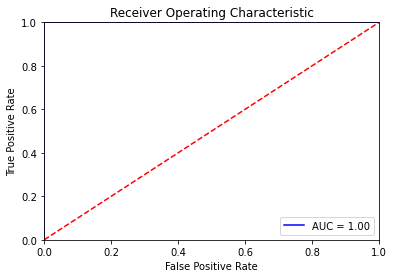

In [150]:
# Compute predicted probabilities on the test set
probs = bert_predict(modle, test_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, test_labels)

,id,target
0,0,0
1,1,0
2,2,1
3,3,1
